In [13]:
import pandas as pd

In [14]:
import graph_tool.all as gt
import numpy as np
%matplotlib inline

from matplotlib import pyplot as plt

In [15]:
# generate a barabasi network
graph = gt.price_network(300000, directed=False, m=1)

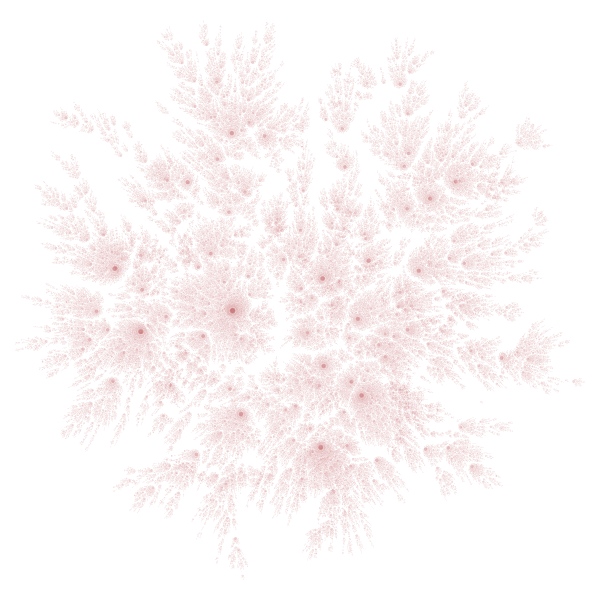

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f628a205fd0, at 0x7f628aac80b8>

In [16]:
gt.graph_draw(graph, output="barabasi.png")

In [17]:
degrees = [v.out_degree() for v in graph.vertices()]


In [6]:
from collections import Counter

In [7]:
degree_count = Counter(degrees)

In [8]:
x = list(degree_count.keys())
y = list(degree_count.values())

Text(0,0.5,'P(k)')

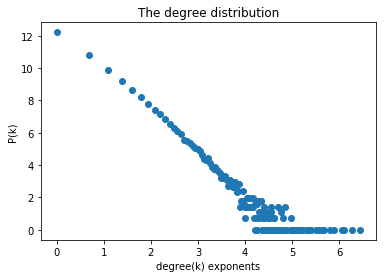

In [9]:
plt.scatter(np.log(x), np.log(y))
plt.title("The degree distribution")
plt.xlabel("degree(k) exponents")
plt.ylabel("P(k)")

## Naive approach

The definition of the clustering coefficient for a complex network is as follows

Let $G = (V,E)$ be a Complex network

$\forall v_i \in V$

$$ C_i = 2 \cdot \frac{e_i}{k_i(k_i − 1)}$$

Where $e_i$ is the number of triangles friends who are also friends of friends
and $k_i(k_i - 1)$ is the total number of friends that could have this property

In [21]:
def number_of_triangles(vertex, graph):
    neighbours = set(vertex.out_neighbours())
    triangles = 0
    for v in neighbours:
        triangles += len(set(v.out_neighbours()) & neighbours)
    return triangles // 2

In [46]:
def local_coeff(vertex, graph):
    num_triangles = number_of_triangles(vertex, graph)
    number_of_triples = vertex.out_degree() * (vertex.out_degree() - 1) / 2
    return num_triangles / number_of_triples if vertex.out_degree() >= 2 else 0

In [49]:
def clustering_coeff_naive(graph, nodelist=None):
        coefs = [local_coeff(n, graph) for n in nodelist] if nodelist  else \
            list(gt.graph_tool.clustering.local_clustering(graph).get_array())
        return np.mean(coefs)

In [ ]:
g = gt.graph_tool.generation

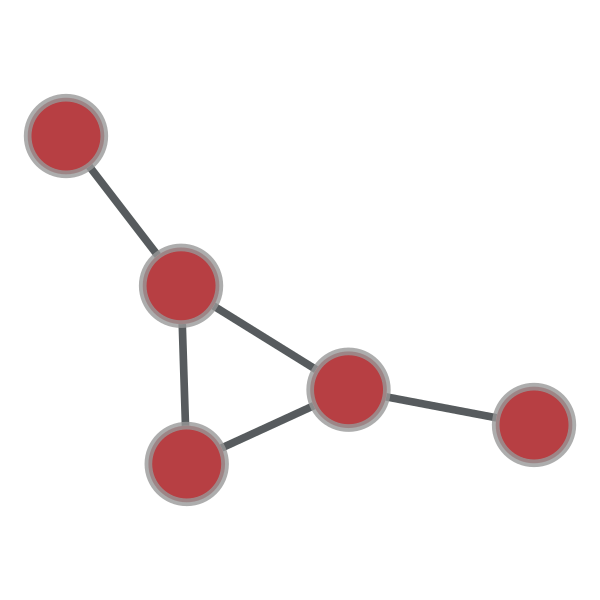

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7fa87b399f98, at 0x7fa87b399c18>

In [74]:
gt.graph_draw(graph)

In [78]:
np.mean([local_coef(i, graph) for i in range(len(list(graph.vertices())))])

0.3333333333333333

In [81]:
np.mean(gt.graph_tool.clustering.local_clustering(graph).get_array())

PropertyArray(0.33333333)

In [79]:
gt.graph_tool.clustering.global_clustering(graph)

(0.42857142857142855, 0.13883218797250715)

In [21]:
coefs = gt.graph_tool.clustering.local_clustering(graph)

In [33]:
coefs = list(coefs.get_array())

## Parallelize

In [19]:
## Disclaimer not working

In [29]:
from functools import reduce

In [31]:
def parallelise(graph, n_sectors):
    all_nodes = list(graph.vertices())
    sector = 0
    sectors = defaultdict(lambda:[])
    # separate into different sectors
    for n in all_nodes:
        sectors[sector].append(n)
        sector += 1 % n_sectors
    
    # calculate the coeff in each sector
    coeffs = {sec: clustering_coeff_naive(graph, nodelist=sectors[sector])}
    
    # sum the  ( usually parallel )
    total_coeff = reduce(sum, map(lambda x:sum(x.values()), sectors))
    return total_coeff / len(all_nodes)

## Pareto

In [40]:
next(map(lambda x: clustering_coeff_naive(graph, )))

10.0

In [50]:
def pareto_method(graph):
    degrees = [v.out_degree() for v in graph.vertices()]
    cutoff = np.percentile(degrees, 80)
    hubs = list(filter(lambda x: x.out_degree() > cutoff, graph.vertices()))
    coeff = clustering_coeff_naive(graph, hubs)
    return coeff / len(degrees)

In [51]:
pareto_method(graph)

0.0

## James' Estimation

In [18]:
def estimate(graph, step):
    nodes = sorted([node for node in graph.vertices() if node.out_degree()> 1], key=lambda node: node.out_degree(), reverse=True)
    last_coeff = local_coef(0)
    for n in nodes[step-1::step]:
        n_coeff = local_coef(n)
        sum_coeff += step * ((n_coeff + last_coeff) / 2)
        last_coeff = n_coeff
    sum_coeff += ((last_coeff) / 2) * step
    return sum_clust / len(list(graph.vertices()))